In [1]:
from heuristic.trainNetwork import TrainNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from multiprocessing import Pool
from functools import partial
from typing import List,Dict
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output


# Heuristic End to End Search Helper Function Test

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Ant Colony Optimization

In [3]:
class Ant:
    def __init__(self,graph:TrainNetwork,data:List[str],startVerticesID:str,endVerticesID:str,distanceGraph:dict):
        self.nodes =  [d for d in data if d != startVerticesID and d != endVerticesID].copy()
        self.traveledPath = []
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.graph = graph
        self.distanceTraveled = 0
        self.travelHistory = []
        self.distanceGraph = distanceGraph
        
    def spawn(self):
        try:
            paths = self.nodes
            shuffle(paths)
            self.nodes = paths.copy()
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Ant.spawn \n"
        
    def selectPath(self,currentNode,pheromoneGraph,pheromone_proximity:float,distance_proximity:float):
        try:
            pathChoices = [ node for node in self.nodes if node != self.endVerticesID and node not in self.traveledPath ]
            observation = {} #{ [toID]:{pheromone,distance} } 
            chance = np.random.rand()
            alpha = pheromone_proximity
            beta = distance_proximity
            
            if len(pathChoices) == 0:
                nextNode = self.endVerticesID
                pathLength = self.distanceGraph[currentNode][nextNode]
                pheromone = pheromoneGraph[currentNode][nextNode]
                observation[nextNode] = {"distance":pathLength,"pheromone":pheromone}
            else:
                for choice in pathChoices:
                    pathLength = self.distanceGraph[currentNode][choice]
                    pheromone = pheromoneGraph[currentNode][choice]
                    observation[choice] = {"distance":pathLength,"pheromone":pheromone}

                cumulativeProbability = 0;
                denominator = sum(
                    [ ((o["pheromone"]**alpha) * ((1/o["distance"])**beta)) for o in list(observation.values())]
                )
                for choice in pathChoices:
                    nominator = (observation[choice]["pheromone"]**alpha)*((1/observation[choice]["distance"])**beta)
                    cumulativeProbability += nominator/denominator
                    if chance <= cumulativeProbability:
                        nextNode = choice
                        break
            return nextNode,observation[nextNode]["distance"],observation[nextNode]["pheromone"],None
                
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,None,None,f"{str(error)} ... error at Ant.selectPath \n"
        
    def findFood(self,pheromoneGraph,distance_proximity,pheromone_proximity):
        try:
            self.traveledPath = []
            distance = 0
            self.distanceTraveled = 0
          
            fromNode = self.startVerticesID
            self.traveledPath.append(fromNode)
            while(True):
                toNode,dist,pheromone,selectPathErr = self.selectPath(
                    fromNode,
                    pheromoneGraph,
                    distance_proximity,
                    pheromone_proximity
                )
                if(selectPathErr is not None): raise selectPathErr
                distance += dist
                self.distanceTraveled += dist
                self.travelHistory.append({
                    "fromID":fromNode,
                    "toID":toNode,
                    "distance": dist,
                    "pheromone":pheromone
                })
                    
                #next city
                fromNode = toNode
                self.traveledPath.append(fromNode)   
                
                #reached
                if(toNode==self.endVerticesID): 
                    self.traveledPath.append(self.endVerticesID)   
                    break
             
                
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Ant.findFood \n"
        
    def releasePheromone(self,pheromoneGraph,evaporation_rate,pheromone_concentration,pheromone_proximity,distance_proximity):
        try:
            alpha=distance_proximity
            beta=distance_proximity
            
            newPheromoneGraph = pheromoneGraph
            for h in self.travelHistory:
                newPheromoneGraph[h["fromID"]][h["toID"]]+= pheromone_concentration/h["distance"]
            
            
            return newPheromoneGraph,None
                    
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ... error at Ant.releasePheromone \n"

In [4]:
def parallel_findFood(ant:Ant,pheromoneGraph,pheromone_proximity,distance_proximity):
    err = ant.findFood(pheromoneGraph,pheromone_proximity,distance_proximity)
    if err : return None, err
    return ant,None

class AntColonyOptimization:
    def __init__(self,graph:TrainNetwork,data:List[str],startVerticesID:str,endVerticesID:str):
        self.graph = graph
        self.data = data.copy()
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.pheromoneGraph = {}
        for i in range(len(data)):
            self.pheromoneGraph [data[i]] = {}
            for j in range(len(data)):
                self.pheromoneGraph [data[i]][data[j]] = 1/len(data)
                
        self.distanceGraph = self.setupDistanceGraph()
                
    def setupDistanceGraph(self):
        locations = [self.startVerticesID] + self.data + [self.endVerticesID]
        distanceGraph = {}
        for fromLoc in locations:
            if  distanceGraph.get(fromLoc) is None:  distanceGraph[fromLoc] = {} 
            for toLoc in locations:
                if fromLoc==toLoc:
                    distanceGraph[fromLoc][toLoc] = 0
                else:
                    travel = self.graph.breadthFirstSearch(fromLoc,toLoc)
                    if(travel.get("err")): raise travel.get("err")
                    distanceGraph[fromLoc][toLoc] =len(travel.get("res").get("path"))
        return distanceGraph
                
    def pheromoneVaporization(self,evaporation_rate):
        try:
            for fromLoc in self.data:
                for toLoc in self.data:
                    self.pheromoneGraph[fromLoc][toLoc] *= (1-evaporation_rate)
        except Exception as error:
            return f"{str(error)} ... error occur at AntColonyOptimization.pheromoneVaporization"
            
        
    def Train(self,population:int,noOfTrips:int,pheromone_concentration:float,evaporation_rate:float, pheromone_proximity:float,distance_proximity:float):
        try:
            antColony = []
            trips = []
            performance_history = []
            evaporation_rate
            best_record = []
            
            #initialize population
            for p in range(population):
                new_ant = Ant(self.graph,self.data,self.startVerticesID,self.endVerticesID,self.distanceGraph)
                spawnErr = new_ant.spawn()
                if(spawnErr is not None) : raise spawnErr
                antColony.append(new_ant)
            
            
            for i in range(noOfTrips):
                #Find Food
#                 for ant in antColony:
#                     findFoodErr = ant.findFood(self.pheromoneGraph,pheromone_proximity,distance_proximity)
#                     if(findFoodErr is not None) : str(findFoodErr)
                
                
                parallel_findFood_param = [ (ant,self.pheromoneGraph,pheromone_proximity,distance_proximity) for ant in antColony]
                ant_pool = []
                with Pool() as pool:
                    pooling_results = pool.starmap(parallel_findFood, parallel_findFood_param)
                    for pooling_result in pooling_results: 
                        ant,findFoodErr = pooling_result
                        if findFoodErr is not None: raise Exception(str(findFoodErr))
                        ant_pool = [*ant_pool,ant]
                antColony = ant_pool          
                    
                # pheromone vaporization
                vaporizationErr = self.pheromoneVaporization(evaporation_rate)
                if(vaporizationErr is not None): raise vaporizationErr
                    
                # release pheromone  
                for ant in antColony:
                        
                    #updates
                    updatedPheromoneGraph, releasePheromoneErr = ant.releasePheromone(
                        self.pheromoneGraph,
                        evaporation_rate,
                        pheromone_concentration, 
                        pheromone_proximity,
                        distance_proximity
                    )
                    if(releasePheromoneErr is not None): raise releasePheromoneErr
                    self.pheromoneGraph = updatedPheromoneGraph
                
                #record best ant
                antColony.sort(key=lambda ant: ant.distanceTraveled)
                if(len(best_record)==0): best_record.append({"path":antColony[0].traveledPath,"distance":antColony[0].distanceTraveled})
                if(len(best_record)>0):
                    if(best_record[0]["distance"]> antColony[0].distanceTraveled):
                        best_record[0]["distance"] =  antColony[0].distanceTraveled
                        best_record[0]["path"] = antColony[0].traveledPath
                    
                #reporting
                performance_history.append(antColony[0].distanceTraveled)
                trips.append(i)
                
                #plot graph
                clear_output(wait=True)
                plt.xlabel('trips')
                plt.ylabel('number of station used')
                plt.plot(trips, performance_history)
                plt.show()
                
            res = [*best_record, *[{"path":ant.traveledPath,"distance":ant.distanceTraveled} for ant in antColony]]
            return res, None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None, f"{str(error)} ... error at AntColonyOptimization.Train() method \n"

# Generate Test Data

In [5]:
stationIDs = trainNetwork.getRandomVerticesID(20).get("res")
# stationIDs = ['AG16','KJ35','AG11','PY21','AG1','PY27','PY22','KG33','KJ5','KJ9','SP8','KJ19','AG6','KG17','AG7','KG34','PY37','SP4','SP14','KJ6']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,PY08,Sri Damansara Timur,"{'lat': '3.20777', 'lon': '101.62866'}"
1,KG22,Maluri,"{'lat': '3.12444', 'lon': '101.72725'}"
2,KJ24,Kelana Jaya,"{'lat': '3.112442', 'lon': '101.604533'}"
3,KJ35,Alam Megah,"{'lat': '3.0230883', 'lon': '101.5720828'}"
4,PY34,UPM,"{'lat': '3.00850', 'lon': '101.70554'}"
5,KJ11,Kampung Baru,"{'lat': '3.1613213', 'lon': '101.7067252'}"
6,PY18,Hospital Kuala Lumpur,"{'lat': '3.17433', 'lon': '101.70076'}"
7,PY19,Raja Uda,"{'lat': '3.16783', 'lon': '101.71104'}"
8,SP26,Taman Perindustrian Puchong,"{'lat': '3.022844', 'lon': '101.6134397'}"
9,KJ16,Bangsar,"{'lat': '3.1276507', 'lon': '101.679149'}"


In [6]:
stationIDs

['PY08',
 'KG22',
 'KJ24',
 'KJ35',
 'PY34',
 'KJ11',
 'PY18',
 'PY19',
 'SP26',
 'KJ16',
 'SP9',
 'KJ31',
 'KJ34',
 'AG8',
 'SP2',
 'KG24',
 'KJ30',
 'KJ32',
 'KJ18',
 'KG16']

# Model Fitting

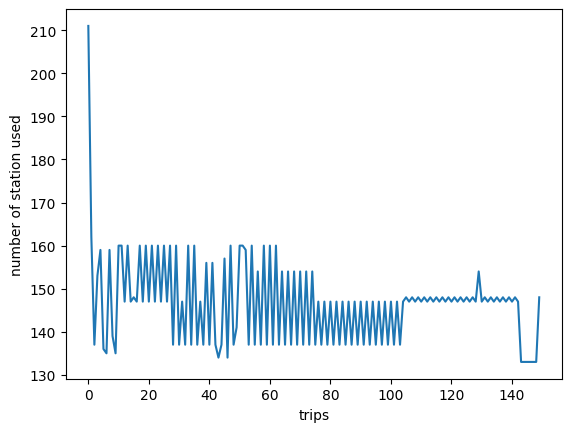

In [7]:
start = stationIDs[0]
end = stationIDs[0]
populationSize = len(stationIDs)
pheromoneConcentration = len(stationIDs)
evaporationRates = 0.05
trips = 150
pheromone_proximity = 1
distance_proximity = 1



aco = AntColonyOptimization(trainNetwork,stationIDs,start,end)
result,err = aco.Train(populationSize,trips,pheromoneConcentration,evaporationRates,pheromone_proximity,distance_proximity)
if(err is not None): print(err)

# Result of Each Ants

In [8]:
pd.DataFrame(result)

,path,distance
0,"[PY08, PY19, PY18, KJ11, PY34, SP26, KJ35, KJ3...",133
1,"[PY08, PY18, PY19, SP2, SP9, KJ18, KJ16, KG16,...",148
2,"[PY08, PY18, PY19, KJ11, AG8, SP9, KG16, KJ16,...",160
3,"[PY08, PY18, PY19, KJ11, AG8, SP9, KG16, KJ16,...",160
4,"[PY08, PY19, PY18, KJ11, AG8, SP9, KG16, KJ16,...",162
5,"[PY08, PY19, PY18, KJ11, AG8, SP9, KG16, KJ16,...",162
6,"[PY08, PY18, PY19, SP2, SP9, SP26, PY34, KJ11,...",163
7,"[PY08, PY19, PY18, SP2, SP9, AG8, KG16, KJ16, ...",164
8,"[PY08, PY19, PY18, SP2, SP9, AG8, KG16, KJ16, ...",164
9,"[PY08, PY18, PY19, SP2, SP9, AG8, KG16, KJ16, ...",166


# Result of Best Ant

In [9]:
soln = [trainNetwork.vertices.get(stationID) for stationID in result[0].get("path")]
pd.DataFrame(soln)

,id,stationName,coordinate
0,PY08,Sri Damansara Timur,"{'lat': '3.20777', 'lon': '101.62866'}"
1,PY19,Raja Uda,"{'lat': '3.16783', 'lon': '101.71104'}"
2,PY18,Hospital Kuala Lumpur,"{'lat': '3.17433', 'lon': '101.70076'}"
3,KJ11,Kampung Baru,"{'lat': '3.1613213', 'lon': '101.7067252'}"
4,PY34,UPM,"{'lat': '3.00850', 'lon': '101.70554'}"
5,SP26,Taman Perindustrian Puchong,"{'lat': '3.022844', 'lon': '101.6134397'}"
6,KJ35,Alam Megah,"{'lat': '3.0230883', 'lon': '101.5720828'}"
7,KJ34,USJ 21,"{'lat': '3.0298519', 'lon': '101.5821081'}"
8,KJ32,Taipan,"{'lat': '3.0478541', 'lon': '101.5901209'}"
9,KJ31,USJ 7,"{'lat': '3.05496', 'lon': '101.59219'}"


### Data population for creating map

In [10]:
stations = result[0].get("path")

paths = []
for i in range(len(stations)):
    if i > 0:
        from_id = stations[i-1]
        to_id = stations[i]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
#     print(path)
    path.pop()
    allPath+=path
allPath+=[stations[len(stations)-1]]
# print(allPath)

{'from': 'PY08', 'to': 'PY08'}


# Visualize with Map

In [11]:
pathData = [trainNetwork.vertices[p] for p in allPath]
locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
        show = True,
        sticky = True,
        lazy   = True
    ).add_to(Map)
    
     
Map